<img src="https://www.lsce.ipsl.fr/Css/img/banniere_LSCE_75.png" width="800px"> <img src="https://www.ipsl.fr/wp-content/themes/ipsltheme/themes/logo/logo_ipsl_2.png" width="60px">

# Plotting ORCA outputs with cartopy and matplotlib

A gallery of plots with the curvilinear ORCA Grid

# Stuff

## Licence

This software is governed by the [CeCILL license](http://www.cecill.info) license under French law and abiding by the rules of distribution of free software. You can use, modify and/ or redistribute the software under the terms of the [CeCILL license](http://www.cecill.info) as circulated by CEA, CNRS and INRIA.

Warning, to install, configure, run, use any of Olivier Marti's software or to read the associated documentation you'll need at least one (1) brain in a reasonably working order. Lack of this implement will void any warranties (either express or implied). O. Marti assumes no responsability for errors, omissions, data loss, or any other consequences caused directly or indirectly by the usage of his software by incorrectly or partially configured personal.


## Contact
mailto:olivier.marti@lsce.ipsl.fr

### SVN Information

In [1]:
SVN = { 'Author' : "$Author: $", 'Date' : "$Date: $", 'Revision': "$Revision: $",
        'Id' : "$Id:  $", 'HeadURL' : "$HeadUrl: $" }

# Initialize

## Needed python modules

### 'Classic' modules

In [2]:
import numpy as np, xarray as xr, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl
import cartopy.mpl.ticker, cartopy.crs as ccrs, cartopy
import importlib, sys, os, pathlib
from matplotlib.path import Path
import matplotlib.patches as mpatches
import shapely as shp
os.environ["PYPROJ_GLOBAL_CONTEXT"]="ON"

### Specific module to simplify access to IPSL model outputs

In [3]:
import libIGCM_sys, sphere
rad = np.deg2rad (1.0)
Mach = libIGCM_sys.Mach()

### Module versions

In [4]:
print ( 'Machine            : ', Mach                )
print ( 'Version python     : ', sys.version         )
print ( 'Version numpy      : ', np.__version__      )
print ( 'Version xarray     : ', xr.__version__      )
print ( 'Version Matplotlib : ', mpl.__version__     )
print ( 'Version Cartopy    : ', cartopy.__version__ )

Machine            :  Spip
Version python     :  3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:51:20) [Clang 16.0.6 ]
Version numpy      :  1.26.4
Version xarray     :  2024.3.0
Version Matplotlib :  3.8.4
Version Cartopy    :  0.23.0


## A specific module to handle ORCA grid particularisms

Use `help(nemo)` to get some details

In [5]:
import nemo
importlib.reload(nemo)
#nemo.set_options (Stack=True)
nemo.__file__

'/Users/marti/Python/Library/nemo.py'

## A module with IPCC color palettes

In [6]:
import IPCC

In [7]:
Ra = nemo.RA

# Read and prepare data

## Using ORCA1 or ORCA2

Use only one of the following cells, and comment the others (switch them to `Raw Text` to make them inactive)

In [8]:
Oname = "orca2" ; nperio = 4

mm = libIGCM_sys.config ( JobName='TR5AS-Vlr01', TagName='IPSLCM5A2', ExperimentName='Holocene', SpaceName='PROD',)
                          #Source = 'TGCC_thredds', TGCC_Group='gen2212', TGCC_User='p86mart', )

mm.Dir    = f'{mm.R_SAVE}/OCE/Analyse/SE'
mm.Period = 'SE_2000_2099_1M'
time_sel = { 'time_counter':slice (0, 2) }

In [9]:
mm

{'TagName': 'IPSLCM5A2', 'SpaceName': 'PROD', 'ExperimentName': 'Holocene', 'JobName': 'TR5AS-Vlr01', 'LongName': None, 'ModelName': None, 'ShortName': None, 'ConfigCard': None, 'ARCHIVE': '/Users/marti/Data', 'STORAGE': '/Users/marti/Data', 'SCRATCHDIR': '/Users/marti/Scratch', 'R_OUT': '/Users/marti/Data/IGCM_OUT', 'R_BUF': '/Users/marti/Scratch/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01', 'R_GRAF': '/Users/marti/GRAF/DATA', 'DB': '/Users/marti/marti/GRAF/DB', 'IGCM_OUT': '/Users/marti/Data/IGCM_OUT', 'R_SAVE': '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01', 'R_FIGR': '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01', 'R_BUFR': '/Users/marti/Scratch/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01', 'REBUILD_DIR': '/Users/marti/Scratch/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/REBUILD', 'POST_DIR': '/Users/marti/Scratch/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/Out', 'R_IN': '/Users/marti/Data/IGCM', 'Host': 'Spip', 'Source': None, 'User': 'marti', 'Group': None, 'IGCM_OUT_name': 'I

## Defines files names

In [10]:
f_T = os.path.join ( mm.Dir, f'{mm.JobName}_{mm.Period}_grid_T.nc' )
f_U = os.path.join ( mm.Dir, f'{mm.JobName}_{mm.Period}_grid_U.nc' )
f_V = os.path.join ( mm.Dir, f'{mm.JobName}_{mm.Period}_grid_V.nc' )
f_W = os.path.join ( mm.Dir, f'{mm.JobName}_{mm.Period}_grid_W.nc' )

if Oname == "orca2" :
    f_g = os.path.join ( mm.R_GRAF, 'ORCA2.1_mesh_mask.nc'   )
    f_c = os.path.join ( mm.R_GRAF, 'orca2.3_coastline.nc'   )
    f_b = os.path.join ( mm.R_GRAF, 'ORCA2.3_subbasins.nc'   )
    f_s = os.path.join ( mm.R_GRAF, 'orca2.3_coastline.json' )
if Oname == "eORCA1.2" : 
    f_g = os.path.join ( mm.R_GRAF, 'eORCA1.2_mesh_mask.nc'  )
    f_c = os.path.join ( mm.R_GRAF, 'eorca1.2_coastline.nc'  )
    f_b = os.path.join ( mm.R_GRAF, 'eORCA1.2_subbasins.nc'  )
    f_s = os.path.join ( mm.R_GRAF, 'eorca1.4.2_coastline.json' )
if Oname == "eORCA1.4" : 
    f_g = os.path.join ( mm.R_GRAF, 'eORCA1.4.2_mesh_mask.nc' )
    f_c = os.path.join ( mm.R_GRAF, 'eorca1.4.2_coastline.nc' )
    f_b = os.path.join ( mm.R_GRAF, 'eORCA1.4.2_subbasins.nc' )
    f_s = os.path.join ( mm.R_GRAF, 'eorca1.4.2_coastline.json' )

print ( f'{f_g = }' )
print ( f'{f_b = }' )
print ( f'{f_c = }' )
print ( f'{f_T = }' )
print ( f'{f_U = }' )
print ( f'{f_V = }' )
print ( f'{f_W = }' )
print ( f'{f_s = }' )

f_g = '/Users/marti/GRAF/DATA/ORCA2.1_mesh_mask.nc'
f_b = '/Users/marti/GRAF/DATA/ORCA2.3_subbasins.nc'
f_c = '/Users/marti/GRAF/DATA/orca2.3_coastline.nc'
f_T = '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/OCE/Analyse/SE/TR5AS-Vlr01_SE_2000_2099_1M_grid_T.nc'
f_U = '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/OCE/Analyse/SE/TR5AS-Vlr01_SE_2000_2099_1M_grid_U.nc'
f_V = '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/OCE/Analyse/SE/TR5AS-Vlr01_SE_2000_2099_1M_grid_V.nc'
f_W = '/Users/marti/Data/IGCM_OUT/IPSLCM5A2/PROD/Holocene/TR5AS-Vlr01/OCE/Analyse/SE/TR5AS-Vlr01_SE_2000_2099_1M_grid_W.nc'
f_s = '/Users/marti/GRAF/DATA/orca2.3_coastline.json'


## Open files

In [11]:
#kw = {'chunks':{"time_counter":8}}

d_g =  xr.open_dataset (f_g, use_cftime=True, decode_times=False, **kw).squeeze ()
d_c =  xr.open_dataset (f_c, use_cftime=True, decode_times=False, **kw).squeeze ()
d_b =  xr.open_dataset (f_b, use_cftime=True, decode_times=False, **kw).squeeze ()

d_T =  xr.open_dataset (f_T, use_cftime=True, decode_times=False, **kw)[time_sel]
d_U =  xr.open_dataset (f_U, use_cftime=True, decode_times=False, **kw)[time_sel]
d_V =  xr.open_dataset (f_V, use_cftime=True, decode_times=False, **kw)[time_sel]
d_W =  xr.open_dataset (f_W, use_cftime=True, decode_times=False, **kw)[time_sel]

/Users/marti/mambaforge/envs/FULL/lib/python3.11/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time_counter" starting at index 8. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


### Use a fixed name for all dimensions to simplify the rest of the notebook
Not depending of the dataset used, the model version, etc ...

In [12]:
udims = nemo.UDIMS

d_T = nemo.unify_dims (d_T, **udims)
d_U = nemo.unify_dims (d_U, **udims)
d_V = nemo.unify_dims (d_V, **udims)
d_W = nemo.unify_dims (d_W, **udims)
d_g = nemo.unify_dims (d_g, **udims)
d_c = nemo.unify_dims (d_c, **udims)
d_b = nemo.unify_dims (d_b, **udims)

## Read variables

In [13]:
thetao = d_T ['thetao']  ; so  = d_T ['so']
lon    = d_T ['nav_lon'] ; lat = d_T ['nav_lat']
depthT = d_T [udims['z']]
jpj, jpi = lon.shape
jeq = nemo.jeq (lat) # Index of equator

# Needed for eORCA1.4.2 with missing lon and lat values
lon, lat = nemo. fill_lonlat (lon, lat, sval=-1)

uo   = d_U ['uo'] ; lonU = d_U ['nav_lon'] ; latU = d_U ['nav_lat']
vo   = d_V ['vo'] ; lonV = d_V ['nav_lon'] ; latV = d_V ['nav_lat']
wo   = d_W ['wo'] ;
depthW = d_W [udims['z']]
e1u  = d_g ['e1u'] ; e1v  = d_g ['e1v']
e2u  = d_g ['e2u'] ; e2v  = d_g ['e2v']
e3u  = d_U ['e3u'] ; e3v  = d_V ['e3v']

tmask = d_g ['tmask']
mask = tmask.isel( {udims['z']:0} )

# Coastline
lon_coast = d_c['lon_coast'] ; lat_coast = d_c['lat_coast'] #; idx_coast=d_c['land_mass']
d_s = open (f_s, 'r')
coast_shp = shp.from_geojson (d_s.read())
coast_poly = cartopy.feature.ShapelyFeature (coast_shp, ccrs.PlateCarree (central_longitude=0), facecolor='none')
d_s.close()

# Oceanic basin mask
atlmsk = d_b ['atlmsk']
pacmsk = d_b ['pacmsk']
indmsk = d_b ['indmsk']

try    : atlmsk_nomed = d_b['atlmsk_nomed']
except : pass

ipcmsk = np.clip (pacmsk + indmsk, 0, 1)

lat1D, lon1D = nemo.latlon1d (lat, lon)

### Create a mask for plotting land masses in vertical sections

In [14]:
land = xr.where (np.isnan (thetao[{udims['t']:0}]), 1.0, np.nan)

## Corrects data and metadata for nice plots

### Corrects longitudes

Near the north pole

In [15]:
%%time
lon  = nemo.fixed_lon (lon )
lonU = nemo.fixed_lon (lonU)
lonV = nemo.fixed_lon (lonV)

CPU times: user 2.92 s, sys: 84.7 ms, total: 3 s
Wall time: 2.97 s


### Force correct periodicity and north pole folding

In [16]:
%%time
thetao = nemo.lbc (thetao, nperio, 'T')
so     = nemo.lbc (so    , nperio, 'T')
uo     = nemo.lbc (uo    , nperio, 'U', -1.)
vo     = nemo.lbc (vo    , nperio, 'V', -1.)
wo     = nemo.lbc (wo    , nperio, 'T')

CPU times: user 49 ms, sys: 34.3 ms, total: 83.2 ms
Wall time: 81.9 ms


### Style and font size for plots

In [17]:
#plt.style.use ("dark_background")
plt.rcParams ['font.size'] = '16'

background = plt.rcParams['figure.facecolor']
foreground = plt.rcParams['lines.color']

### Get logo files

In [18]:
def GetFile ( url, File='Logo.png' ) : 
    import requests, os
    from pathlib import Path
    File = Path (File)
    if not File.exists () :
        data = requests.get(url).content

In [19]:
def GetLogo ( url, File='Logo.png' ) : 
    import requests, os
    from pathlib import Path
    File = Path (File)
    if "http" in url : 
        suffix = File.suffix
        if suffix == '' : 
            suffix = '.png'
            File = File + suffix
        if not File.exists () :
            data = requests.get(url).content
            file = open ( f'{File}', 'wb')
            file.write (data)
        Logo = mpl.image.imread ( f'{File}')
    else :
        Logo = mpl.image.imread (url)
    return Logo

In [20]:
LogoIPSL = GetLogo ( "https://www.archives.ipsl.fr/extension/design_ipsl/design/standard/images/logo_ipsl.png", 'Logo_IPSL.png')
LogoNEMO = GetLogo ( "https://www.nemo-ocean.eu/doc/img107.png", 'Logo_NEMO.png' )

### Function to add a WaterMark

In [21]:
def WaterMark ( ax, Logo, zoom=0.5, xy=(0.,0.), alpha=0.8, xycoords='axes fraction', bboxprops={'lw':0}) :
    imagebox = mpl.offsetbox.OffsetImage ( Logo, zoom=zoom, alpha=alpha )
    imagebox.image.axes = ax
    ao = mpl.offsetbox.AnnotationBbox (imagebox, xy=xy, xycoords=xycoords, bboxprops=bboxprops)  # method 2
    ao.patch.set_alpha(0)
    return ax.add_artist (ao)

# Plots

## Using `find_ji`
Utility to find index for a given position

### T/S diagram at single point

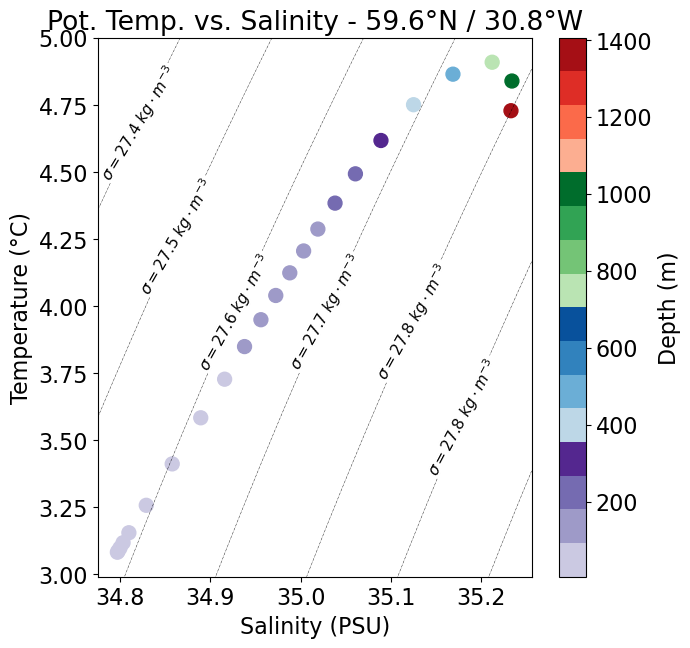

In [22]:
# Set lat/lon 
lat_data = 60. ; lon_data = -30.

point = nemo.find_ji (lat_data, lon_data, lat, lon, mask=1.0, verbose=False, out='dict')

fig, ax = plt.subplots ( figsize=(7,7) )

# plot T/S values
tt = thetao.isel (point).mean (dim='time_counter')
ss = so.isel     (point).mean (dim='time_counter')
zz = ss.olevel

msca = ax.scatter (ss, tt, marker='o', s=100, c=zz, cmap=IPCC.cmap.MultiCat_4)
ax.set_xlabel ('Salinity (PSU)')
ax.set_ylabel ('Temperature (°C)')

xx = ax.get_xlim () ; yy = ax.get_ylim()

# Plot rho isolines in background
Ttab = xr.DataArray ( np.linspace ( yy[0], yy[1], 20), dims=('Temperature',))
Stab = xr.DataArray ( np.linspace ( xx[0], xx[1], 20), dims=('Salinity'   ,))
Rtab = nemo.rhop (Ttab, Stab)-1000

mrho = ax.contour ( Stab, Ttab, Rtab, colors='k', linewidths=0.3, linestyles='-.' )
ax.set_xlim (xx) ; ax.set_ylim (yy)
ax.clabel (mrho, colors=['k'], manual=False, inline=True, fmt='$\sigma=${:3.1f} $kg \cdot m^{{-3}}$'.format, fontsize='x-small' )

ax.set_title ( f"Pot. Temp. vs. Salinity - {cartopy.mpl.ticker.LatitudeFormatter (number_format='.1f')(lat[point])} / {cartopy.mpl.ticker.LongitudeFormatter (number_format='.1f', degree_symbol=u'°')(lon[point])}")

plt.colorbar (msca, label='Depth (m)')

### Plot along a WOCE Section

In [23]:
#### Get WOCE section

url = 'https://www.ncei.noaa.gov/data/oceans/ncei/ocads/data/0115001/a01e_hy1.csv'
file = 'a01e_hy1.csv'
WS = GetFile (url, File=file)

# Read position of stations
data_section = pd.read_csv (file, header=5).dropna()
lat_data = data_section.LATITUDE ; lon_data=data_section.LONGITUDE
lat_data = xr.DataArray ( lat_data, dims=('Point',))[1:]
lon_data = xr.DataArray ( lon_data, dims=('Point',))[1:]

# Compute position of section in nemo grid
section = nemo.find_ji (lat_data[1::1], lon_data[1::1], lat, lon, mask=1.0, verbose=False, drop_duplicates=True, out='xr' )

In [24]:
lon_data

<xarray.DataArray 'LONGITUDE' (Point: 1209)> Size: 10kB
array([-42.5067, -42.5067, -42.5067, ..., -14.2533, -14.2533, -14.2533])
Coordinates:
  * Point    (Point) int64 10kB 2 3 4 5 6 7 8 ... 1205 1206 1207 1208 1209 1210

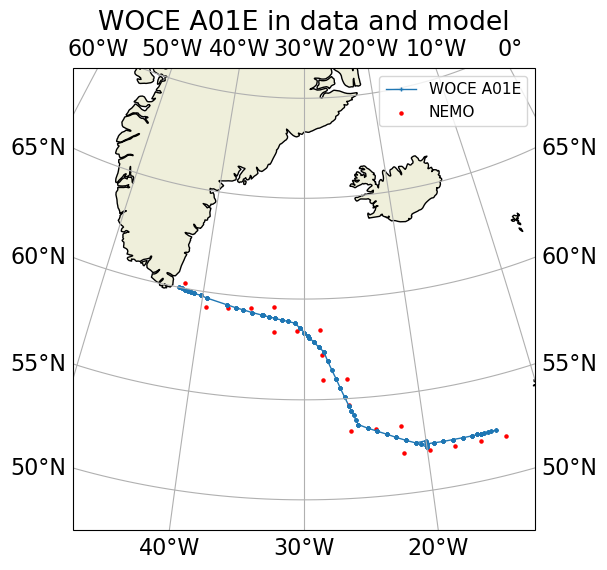

In [25]:
# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
#ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection
ProjPlot = ccrs.Orthographic (central_longitude=-30, central_latitude=60) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot} )

ax.plot    ( lon_data, lat_data, transform=ProjIn, label='WOCE A01E', marker='+', markersize=3, lw=1)
ax.scatter ( lon[section], lat[section], transform=ProjIn, c='red', label='NEMO', s=5 )

width = 0.2 ; ax.set_xlim (-nemo.RA*width, nemo.RA*width) ; ax.set_ylim (-nemo.RA*width, nemo.RA*width)

ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)

ax.set_title ( 'WOCE A01E in data and model' )

ax.legend (fontsize='x-small')

### Compute distance along track

In [26]:
import sphere
importlib.reload(sphere)

nn = len(lat[section])
dist_a = np.empty ( (nn,) )
dist_a[0] = 0
for ji in np.arange(nn-1)+1 : 
    dist_a[ji] = dist_a[ji-1] + sphere.distance ( lat[section][ji-1], lon[section][ji-1], 
                                                  lat[section][ji], lon[section][ji], radius=Ra/1000)
dist_a = xr.DataArray ( dist_a, dims=('distance',), coords=(dist_a,))
dist_a.attrs.update ( {'units':'km'} )

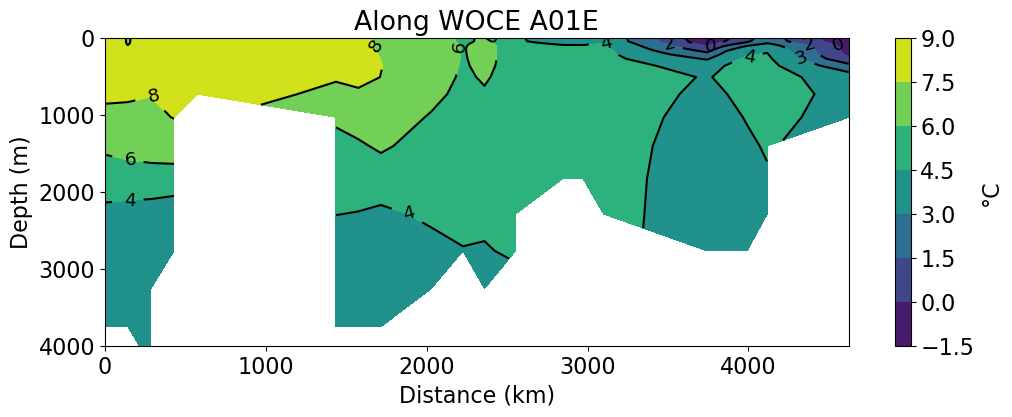

In [27]:
fig, ax = plt.subplots ( figsize=(12,4) )

mcon = ax.contourf ( dist_a, depthT, thetao[0,:, section[0], section[1]], cmap=mpl.cm.viridis )
mlin = ax.contour  ( dist_a, depthT, thetao[0,:, section[0], section[1]], colors='k' )

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} '.format, fontsize='small' )

#ax.set_xlim (-45,-10)
ax.set_ylim (0, 4000)

#ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f'))

ax.set_xlabel('Distance (km)')
ax.set_ylabel('Depth (m)')

ax.set_title ( 'Along WOCE A01E')

plt.colorbar (mcon, label="°C")
             
ax.invert_yaxis()

## Map

### Robinson

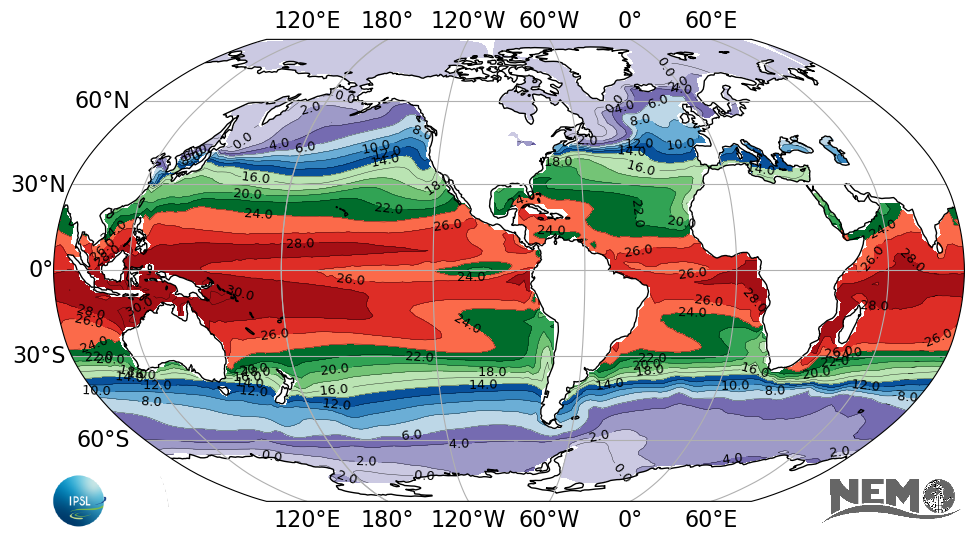

In [28]:
# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
#palet  = mpl.cm.viridis
palet = IPCC.cmap.MultiCat_4
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(15,6), subplot_kw={'projection':ProjPlot} )
ax.set_global ()

# Select data. We use lbc_plot to have nice plots in any projection
# lbc_plot will set to np.nan the duplicate points at the north pole folding
# It keeps the duplicate points for the east-west periodicity
tt = nemo.lbc_plot (thetao[{udims['t']:0, udims['z']:0}], nperio=nperio, cd_type='T')

# Color filing
mmap = ax.contourf (lon, lat, tt, 
                    cmap=cmap, levels=levels, transform=ProjIn)
    
# Contour lines
mlin = ax.contour (lon, lat, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()

def WaterMark ( ax, Logo, zoom=0.5, xy=(0.,0.), alpha=0.8, xycoords='axes fraction', bboxprops={'lw':0}) :
    imagebox = mpl.offsetbox.OffsetImage ( Logo, zoom=zoom, alpha=alpha )
    imagebox.image.axes = ax
    ao = mpl.offsetbox.AnnotationBbox (imagebox, xy=xy, xycoords=xycoords, bboxprops=bboxprops)  # method 2
    ao.patch.set_alpha(0)
    ax.add_artist (ao)

WaterMark ( ax=ax, Logo=LogoNEMO, zoom=0.2, xy=(0.92,0.), alpha=1, xycoords='axes fraction', bboxprops={'lw':0})
WaterMark ( ax=ax, Logo=LogoIPSL, zoom=0.5, xy=(0.1 ,0.), alpha=1, xycoords='axes fraction', bboxprops={'lw':0})

## Orthographic

CPU times: user 1.35 s, sys: 13.3 ms, total: 1.36 s
Wall time: 1.37 s


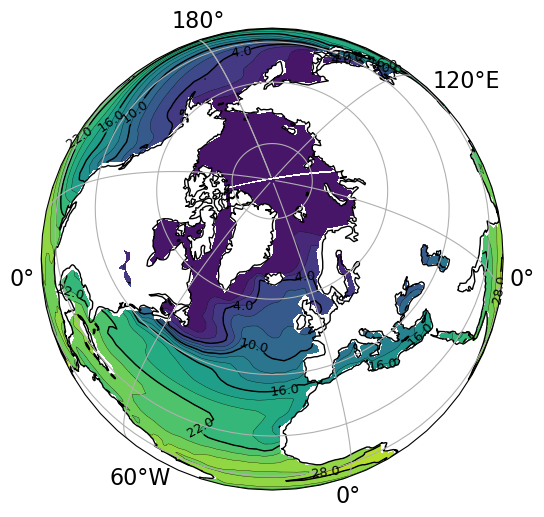

In [29]:
%%time
import cartopy.geodesic
cartopy.geodesic.pyproj.set_use_global_context (active=True)

# Creates the color palette
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=70)

# Creates the figure
fig = plt.figure (figsize=(15,6))

# Creates the viewport, with the associated projection
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

ax.set_global ()

# Select data. We use lbc_plot to have nice plots in any projection
# lbc_plot will set to np.nan the duplicate points at the north pole folding
# it keeps the duplicate points for the east-west periodicity
tt = nemo.lbc_plot (thetao[{udims['t']:0, udims['z']:0}], nperio=nperio, cd_type='T')

# Color filing
mmap = ax.contourf (lon, lat, tt, 
                    cmap=cmap, norm=norm, levels=levels, transform=ProjIn,)
    
# Contour lines
mlin3 = ax.contour (lon, lat, tt, colors='k', levels=levels[::3], transform=ProjIn, linewidths=1)
mlin  = ax.contour (lon, lat, tt, colors='k', levels=levels, transform=ProjIn, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin3, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Beautify
ax.gridlines (draw_labels=True, crs=ProjIn,)
ax.coastlines ()

# Color bar

## Plot real coastline of ORCA

### Robinson projection

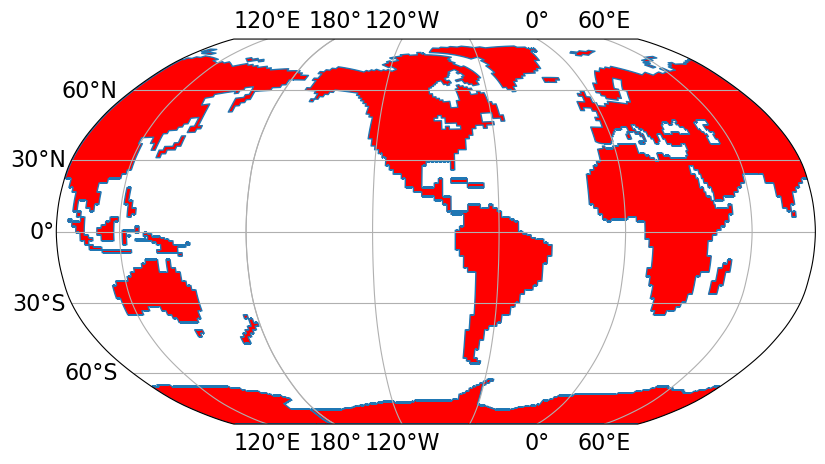

In [30]:
 # Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 
    
# Projection for plots
ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection
   
# Creates the figure
fig = plt.figure (figsize=(12,5))

# Creates the viewport, with the associated projection
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)
ax.set_global ()

# Plot real coastline and continent of ORCA
# ===========================
ax.add_feature (coast_poly, facecolor='red', edgecolor=foreground)

ax.gridlines (draw_labels=True, crs=ProjIn)

### Polar projection

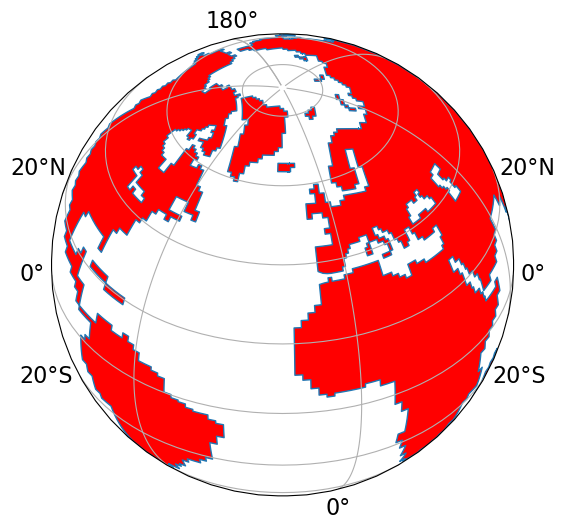

In [31]:
# Describe the model projection in the file
ProjIn = ccrs.PlateCarree (central_longitude=0) 

# Projection for plots
ProjPlot = ccrs.Orthographic (central_longitude=-20, central_latitude=40) # Plotted projection

# Creates the figure
fig, ax = plt.subplots ( figsize=(8,6), subplot_kw={'projection':ProjPlot} )

ff = 1 ; ax.set_xlim (-Ra*ff, Ra*ff) ; ax.set_ylim (-Ra*ff, Ra*ff)

# Plot real coastline and contient of ORCA
# ===========================
ax.add_feature (coast_poly, facecolor='red', edgecolor=foreground)

ax.gridlines (draw_labels=True, crs=ProjIn)

## Vertical sections

### Vertical section at Equator

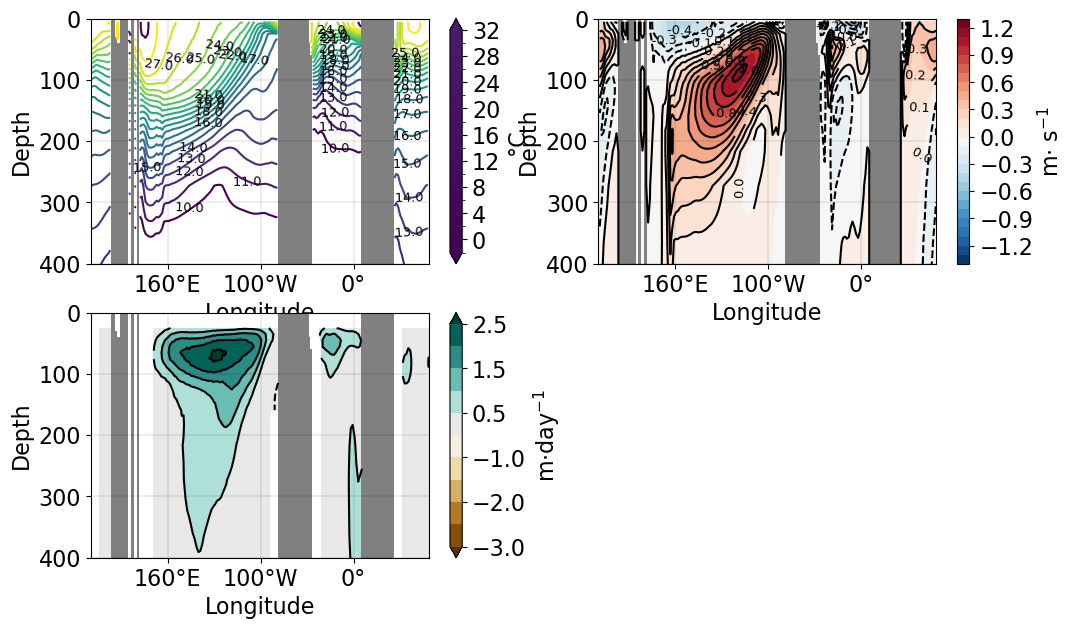

In [32]:
fig = plt.figure ( figsize=(12, 7))
plt.tight_layout ()

# Section of temperature
# ======================
levels = np.arange (10, 32.001, 1)
cmap   = mpl.cm.viridis
#colors = cmap (np.linspace (0, 1, len(levels)+1))
#norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False)
ax = fig.add_subplot (2, 2, 1)

# Contour lines
mcon = ax.contour (lon[jeq], depthT, thetao[{udims['t']:0, udims['y']:jeq}], colors=colors, levels=levels)

# Labels contour lines
ax.clabel (mcon, inline=False,  colors='k', # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

# Plot land masses
ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0)
#plt.colorbar (mcon, orientation='vertical', ax=ax, label="°C")
plt.colorbar (mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label='°C' )
ax.set_xlabel("Longitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

# Section of zonal velocity
# =========================
levels = np.arange (-1.4, 1.4, 0.1)
levels = np.delete (levels, np.where(levels == 0))

cmap   = IPCC.cmap.temp
#colors = cmap (np.linspace (0, 1, len(levels)+1))
#colors[len(levels)//2-1] = [0.98]
#norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False)

ax = fig.add_subplot (2, 2, 2)

mmap = ax.contourf (lon[jeq], depthT, uo[{udims['t']:0, udims['y']:jeq}], 
             cmap=cmap, levels=levels)

mcon  = ax.contour (lonU[{udims['y']:jeq}], depthT, uo[{udims['t']:0, udims['y']:jeq}], colors='k', levels=levels)

ax.clabel (mcon, inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.pcolor (lon[{udims['y']:jeq}], depthT, land[{udims['y']:jeq}], cmap='gray', vmin=0, vmax=2, shading='auto')
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

ax.set_ylim (400,0)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r'm$\cdot$ s$^{-1}$')
ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)

# Section of vertical velocity
# ============================
levels = np.arange (-3, 3, 0.5)
levels = np.delete (levels, np.where(levels == 0))
palet  = cmap = IPCC.cmap.precip
colors = palet (np.linspace (0, 1, len(levels)+1))
colors [len(levels)//2+1] = [0.9]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 3)

# Smoothing vertical velocity
ww = wo[{udims['t']:0}].rolling(olevel=3, y=3, x=5).mean()[{udims['y']:jeq}]*86400

mmap = ax.contourf (lonU[jeq], depthT, ww, colors=colors, norm=norm, levels=levels, extend='both')

mcon  = ax.contour (lonU[{udims['y']:jeq}], depthT, ww, colors='k', levels=levels)

ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0)
plt.colorbar (mmap, orientation='vertical', ax=ax, label=r"m$\cdot$day$^{-1}$")
ax.set_xlabel("Longitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)

ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))


### Vertical section accross equator

Slice at longitude -122.0


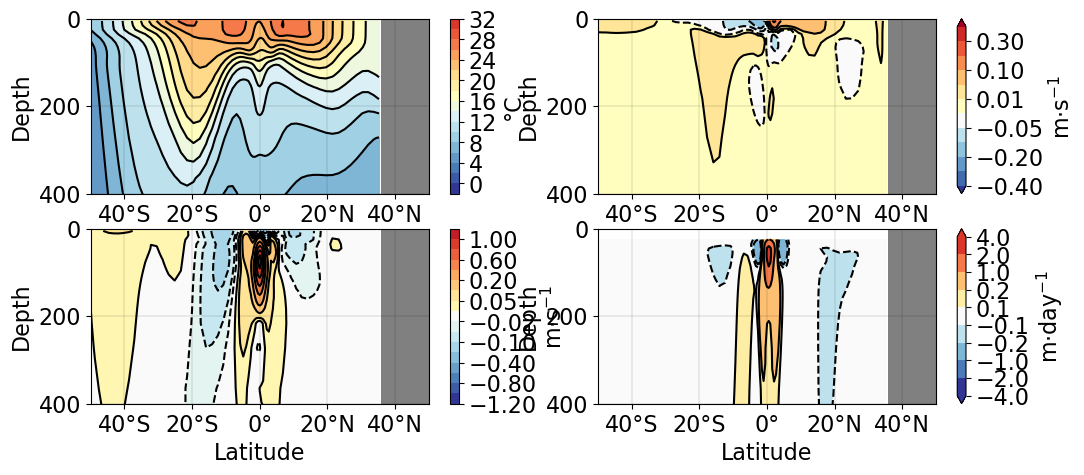

In [33]:
fig = plt.figure ( figsize=(12,5) )
plt.tight_layout ()

# Section of temperature
# ======================
xcoupe = 80 ; ycoupe = slice (jeq-jpj//3,jeq+jpj//3)
levels = np.arange (-2, 32.1, 2.)
palet  = mpl.cm.mpl.cm.RdYlBu_r
colors = palet (np.linspace ( 0, 1, len(levels)+1) )
norm   = mpl.colors.BoundaryNorm (levels, ncolors=palet.N, clip=False)

ax = fig.add_subplot (2, 2, 1)
mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, thetao[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], 
             colors=colors, norm=norm, levels=levels)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, thetao[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], colors='k', levels=levels)

# Add land masses
ax.pcolor (lat[ycoupe, xcoupe], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400,0) ; ax.set_xlim (-50,50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label="°C")
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

print ( "Slice at longitude {:3.1f}".format(lon[{udims['y']:jeq, udims['x']:xcoupe}].values ) )

# Section of meridional velocity
# ==============================

levels = [-0.4, -0.3, -0.2, -0.1, -0.05, -0.01, 0.01, 0.05, .1, .2, .3, .4]
cmap   = mpl.cm.RdYlBu_r
colors = cmap (np.linspace (0, 1, len(levels)+1))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 2)

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, vo[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], 
             colors=colors, norm=norm, levels=levels, extend='both')

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, vo[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], colors='k', levels=levels)

ax.pcolor (lat[{udims['y']:ycoupe, udims['x']:xcoupe}], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2)

ax.set_ylim (400,0) ; ax.set_xlim (-50,50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label='m$\cdot$s$^{-1}$')
ax.set_xlabel("Latitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

# Section of zonal velocity
# =========================
levels = [-1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.1, -0.05, -0.02, 0.02, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
cmap   = mpl.cm.RdYlBu_r
colors = cmap (np.linspace (0, 1, len(levels)))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 3)

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, uo[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], 
             colors=colors, norm=norm, levels=levels)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, uo[{udims['t']:0, udims['y']:ycoupe, udims['x']:xcoupe}], colors='k', levels=levels)

ax.pcolor (lat[{udims['y']:ycoupe, udims['x']:xcoupe}], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400, 0) ; ax.set_xlim (-50, 50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label='m$\cdot$s$^{-1}$')
ax.set_xlabel("Latitude") ; ax.set_ylabel("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

# Slice of vertical velocity
# ==========================
levels = [-4, -2, -1, -0.2, -0.1, 0.1, 0.2, 1, 2, 4]
palet  = mpl.cm.RdYlBu_r
colors = palet (np.linspace (0, 1, len(levels)))
colors[len(levels)//2-1] = [0.98]
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N, clip=False, extend='both')
ax = fig.add_subplot (2, 2, 4)

# Smoothing vertical velocity
ww = wo[{udims['t']:0}].rolling(olevel=3, y=3, x=3).mean()[{udims['y']:ycoupe, udims['x']:xcoupe}]*86400

mmap = ax.contourf (lat[ycoupe, xcoupe], depthT, ww, colors=colors, norm=norm, levels=levels, extend='both' )

mcon = ax.contour (lat[{udims['y']:ycoupe, udims['x']:xcoupe}], depthT, ww, colors='k', levels=levels)

ax.pcolor (lat[ycoupe, xcoupe], depthT, land[:, ycoupe, xcoupe], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_ylim (400, 0) ; ax.set_xlim (-50, 50)
plt.colorbar (mmap, orientation='vertical', ax=ax, label='m$\cdot$day$^{-1}$')
ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth")
ax.grid(color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

## Surface currents

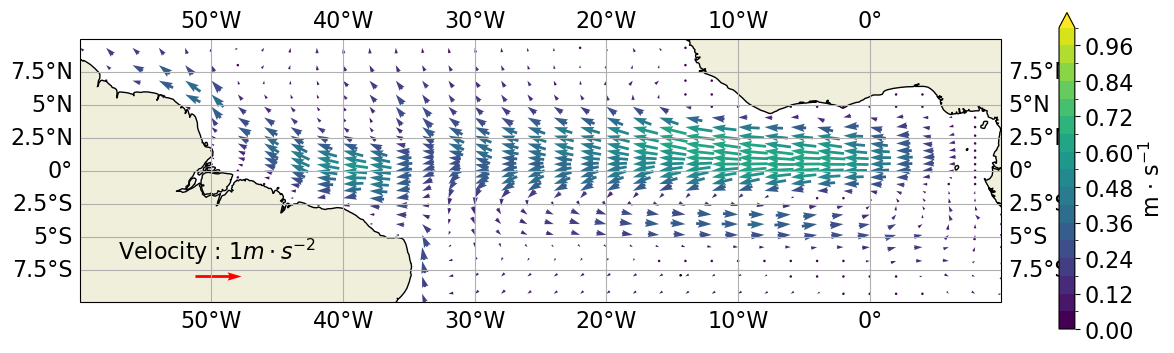

In [34]:
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (0, 1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.PlateCarree (central_longitude=270)

fig, ax = plt.subplots ( figsize=(12,5), subplot_kw={'projection':ProjPlot} )

plt.tight_layout ()

# Vector components are averaged at T point
ux = nemo.u2t ( uo[{udims['t']:0, udims['z']:0}], nperio=nperio )
vy = nemo.v2t ( vo[{udims['t']:0, udims['z']:0}], nperio=nperio )
tt = thetao[{udims['t']:0, udims['z']:0}].values
uv = np.sqrt (ux*ux + vy*vy)

ux = ux.where (uv!=0, np.nan)

mver = ax.quiver (lon.values, lat.values, 
                  ux.values, vy.values, uv.values,
                  pivot='tip', scale=20, width=3E-3, transform=ProjIn,
                  cmap=cmap, norm=norm)
#ax.quiverkey (mver, X=0.15, Y=0.1, U=1, color='red', label=r'Velocity : 1 m $\cdot$ s^${-1}$', labelpos='N')
ax.quiverkey (mver, X=0.15, Y=0.1, U=1, color='red', label=r'Velocity : $1 m\cdot s^{-2}$ ', labelpos='N')

ax.set_extent ( ( -60, 10, -10, 10,), crs=ProjIn ) 

ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)
ax.gridlines (draw_labels=True, crs=ProjIn)

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label='m $\cdot$ s$^{-1}$', shrink=0.7)
#scalebar.scale_bar(ax, location = (0.5,0.15), length=1000, color='red')

## Vertical sections of currents

### Equator section of currents

fact_u = <xarray.DataArray 'RA' ()> Size: 8B
array(4.64632796e-05) fact_w = 1.925 fact_w/fact_u = <xarray.DataArray 'RA' ()> Size: 8B
array(41430.5666397)


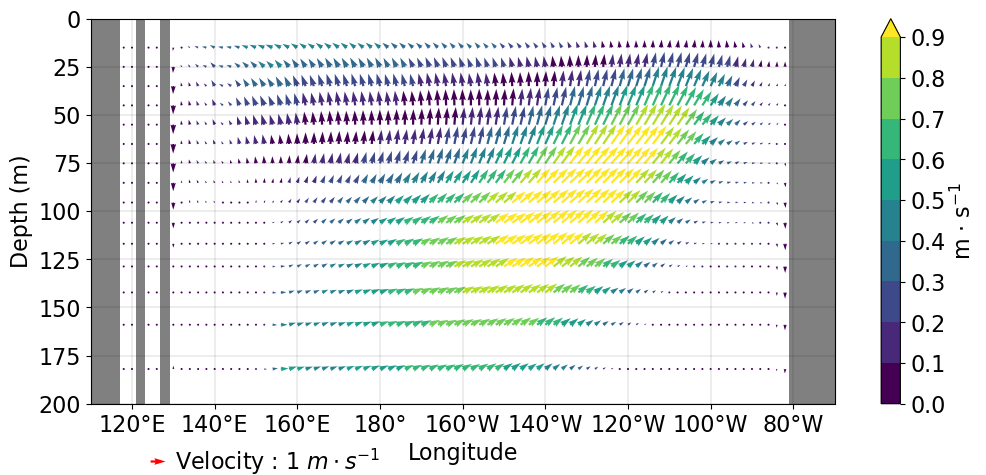

In [35]:
fig = plt.figure ( figsize=(12, 5) )


levels = np.arange (0, 1, 0.1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1)
ax.set_ylim (200,0) ; ax.set_xlim (110-360, 290-360)

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y =ax.get_window_extent().height
delta_X =ax.get_window_extent().width

fact_u  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

print ( f'{fact_u = } {fact_w = } {fact_w/fact_u = }' )

ux = nemo.u2t ( uo[:,:,jeq].mean (dim=udims['t']), nperio=nperio)
wz = nemo.w2t ( wo[:,:,jeq].mean (dim=udims['t']), zdim='olevel', zcoord=ux.olevel) 
uw = np.sqrt (ux*ux + wz*wz)
ux = ux.where(uw!=0, np.nan)

mver = ax.quiver (lon[jeq].values, depthT.values, 
                  ux.values, (wz*fact_w/fact_u).values, uw.values,
                  pivot='tail', scale=50, width=3E-3, cmap=cmap, norm=norm)

ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=-0.15, U=1, color='red', label='Velocity : 1 $m \cdot s^{-1}$', labelpos='E')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label='m $\cdot$ s$^{-1}$')

### Section of current accros the equator

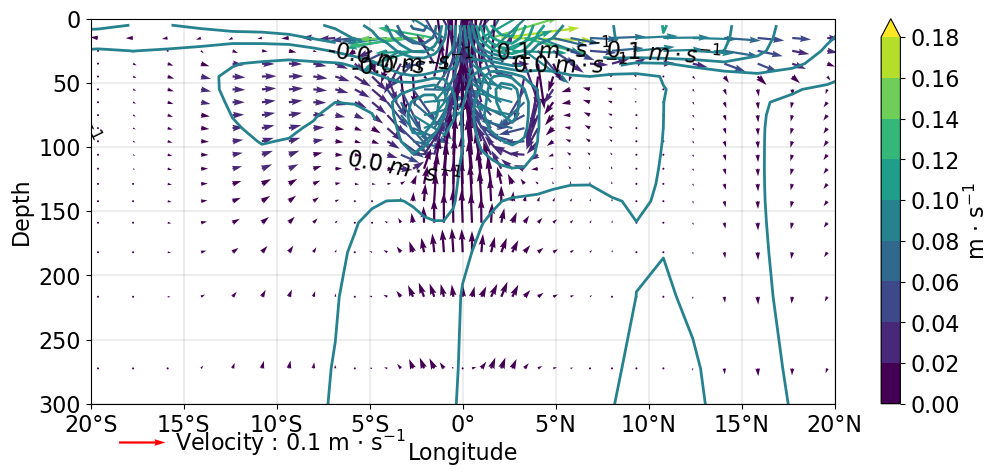

In [36]:
importlib.reload (nemo)
fig = plt.figure ( figsize=(12,5) )
plt.tight_layout () 

# Slice current
xcoupe = int(jpi*0.4) ; ycoupe = slice (jeq-jpj//3,jeq+jpj//3)
levels = np.arange (0, 0.2, 0.02)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1, adjustable='box')
ax.set_ylim (300,0) ; ax.set_xlim (-20, 20)

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

vy = nemo.u2t (vo[:, :, ycoupe, xcoupe].mean(dim=udims['t']), nperio=0)
wz = nemo.w2t (wo[:, :, ycoupe, xcoupe].mean(dim=udims['t']), zdim='olevel', zcoord=vy.olevel) 
vw = np.sqrt (vy*vy + wz*wz)
vy = vy.where(vw!=0, np.nan)

mcon = ax.contour (lat[ycoupe, xcoupe], depthT, vy, 
            levels=np.arange(-1,1,0.025), linewidths=2, cmap=cmap) #colors='grey')

ax.clabel (mcon, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt=r'{:3.1f} $m \cdot s^{{-1}}$'.format, 
        fontsize='medium' )

mver = ax.quiver (lat[ycoupe, xcoupe].values, depthT.values, 
                  vy.values, (wz*fact_w/fact_v).values, vw.values,
                  pivot='tail', width=3E-3, 
                  cmap=cmap, norm=norm)

ax.pcolor (lat[ycoupe, xcoupe].values, depthT.values, land[:, ycoupe, xcoupe], 
           cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=-0.1, U=0.1, label='Velocity : 0.1 m $\cdot$ s$^{-1}$', 
              labelpos='E', color='red', coordinates='axes')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label='m $\cdot$ s$^{-1}$')

### Vertical plot with separation depth

Using a vertical transform

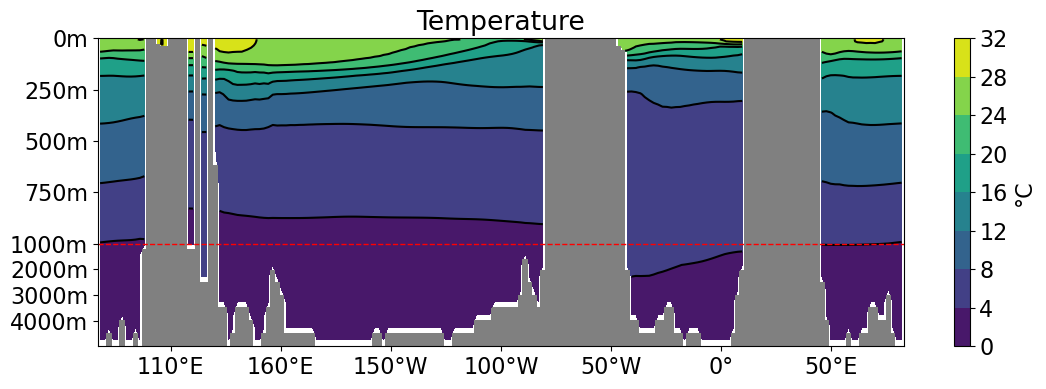

In [37]:
importlib.reload (nemo)

# Transformation functions for the vertical coordinates
depth0= 1000  # Separation depth
zmax  = 5000  # Maximum depth
ratio = 0.5    # Ratio of deep part over surface part
fact = (ratio * depth0 / (zmax - depth0))**0.5
def depth2comp (pz) : return nemo.depth2comp (pz, depth0=depth0, fact=fact)
def comp2depth (pz) : return nemo.comp2depth (pz, depth0=depth0, fact=fact)

fig = plt.figure ( figsize=(13,4) )
ax  = fig.add_subplot (1,1,1)

mmap = ax.contourf ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:] )
mlin = ax.contour  ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:], colors='k' )

ax.set_ylim (depth2comp(zmax), depth2comp(0.5))
ax.set_yscale (mpl.scale.FuncScale (ax, (depth2comp, comp2depth)))

# Ticks
## Longitude ticks
fmtX = cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f')
ax.xaxis.set_major_formatter (fmtX)

## Depth ticks
### Ticks for the upper part
yticks1 = mpl.ticker.MultipleLocator(base= 250.0).tick_values ( 0    , depth0)
### Ticks for the deep part
yticks2 = mpl.ticker.MultipleLocator(base=1000.0).tick_values (depth0, zmax  )
yticks = np.concatenate ( (yticks1[1:-2], [depth0], yticks2[2:-2]))
                                                              
fmtY = '{:.0f}m'.format
ax.set_yticks ( depth2comp (yticks)) ; ax.set_yticklabels ( [fmtY(y) for y in yticks] )

ax.pcolor (lon1D, depth2comp(depthT), land[:,jeq], cmap='grey', vmin=0, vmax=2)

### Plot a line at the separation depth
ax.plot ( ax.get_xlim(), [depth0, depth0], lw=1, color='red', linestyle='dashed')

ax.set_title ('Temperature')
plt.colorbar (mmap, label='°C')

### Vertical vector plot with separation depth

(-250.0, -60.0) (222.4744871391589, 0.5)
ax.get_ylim()=(222.4744871391589, 0.0)


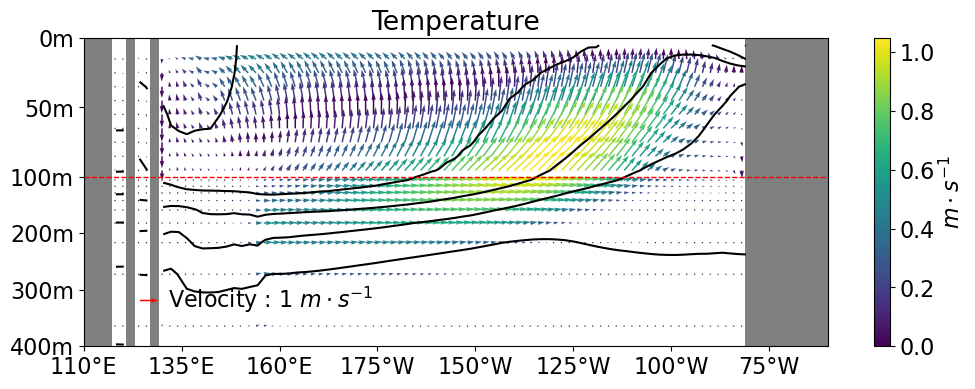

In [38]:
importlib.reload (nemo)

# Transformation functions for the vertical coordinates
depth0= 100    # Separation depth
zmax  = 400    # Maximum depth
ratio = 0.5    # Ratio of deep part over surface part
fact = (ratio * depth0 / (zmax - depth0))**0.5
def depth2comp (pz) : return nemo.depth2comp (pz, depth0=depth0, fact=fact)
def comp2depth (pz) : return nemo.comp2depth (pz, depth0=depth0, fact=fact)

fig = plt.figure ( figsize=(12,4) )
ax  = fig.add_subplot (1,1,1)

#mmap = ax.contourf ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:] )
mlin = ax.contour  ( lon1D, depth2comp(depthT), thetao[0,:,jeq,:], colors='k' )

ax.set_ylim (depth2comp(zmax), depth2comp(0.5))
ax.set_xlim ( -250, -60)

#ax.set_yscale (mpl.scale.FuncScale (ax, (depth2comp, comp2depth)))

print ( ax.get_xlim(), ax.get_ylim())
# Ticks
## Longitude ticks
fmtX = cartopy.mpl.ticker.LongitudeFormatter (number_format='.0f')
ax.xaxis.set_major_formatter (fmtX)

## Depth ticks
### Ticks for the upper part
yticks1 = mpl.ticker.MultipleLocator(base= 50.0).tick_values ( 0    , depth0)
### Ticks for the deep part
yticks2 = mpl.ticker.MultipleLocator(base=100.0).tick_values (depth0, zmax  )
yticks = np.concatenate ( (yticks1[1:-2], [depth0], yticks2[2:-1]))

fmtY = '{:.0f}m'.format
ax.set_yticks ( depth2comp (yticks)) ; ax.set_yticklabels ( [fmtY(y) for y in yticks] )

### Plot a line at the separation depth
ax.plot ( ax.get_xlim(), [depth0, depth0], lw=1, color='red', linestyle='dashed')
print ( f'{ax.get_ylim()=}' )

ax.set_title ('Temperature' )

ux = nemo.u2t (uo[:,:,jeq].mean (dim=udims['t']), nperio=nperio)
wz = nemo.w2t (wo[:,:,jeq].mean (dim=udims['t']), zdim='olevel', zcoord=ux.olevel)
uw = (ux*ux + wz*wz)**0.5

# Computes scale factors to get correct direction of vectors
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = ax.get_window_extent().height
delta_X = ax.get_window_extent().width

fact_c = xr.where ( ux.olevel<depth0, 1./(1.+ratio), ratio/(1.+ratio))
fact_d = xr.where ( ux.olevel<depth0, depth0, zmax-depth0 )

fact_u = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w = delta_Y * fact_c / fact_d

#u,w = nemo.normalize_uv (ux, wz*fact_w/fact_u)
u,w = ux, wz*fact_w/fact_u

mver = ax.quiver (lon[jeq].values, depth2comp(depthT),
                  u.values, w.values,
                  uw.values, pivot='tail', scale=40,
                  width=2E-3)
ax.pcolor (lon[jeq], depthT, land[:,jeq], cmap='gray', vmin=0, vmax=2)

ax.quiverkey (mver, X=0.1, Y=0.15, U=1, color='red', label='Velocity : 1 $m \cdot s^{-1}$', labelpos='E')

plt.colorbar (mver, ax=ax, label="$m \cdot s^{-1}$")

## Surface currents with a projection

### Computes eastward and northward components of the current 

Velocities are averaged at the T point

#### Compute sinus and cosinus of model's directions with respect to east

In [39]:
gsinT, gcosT = nemo.angle (lon, lat , nperio, cd_type='T') 

#### Rotate the velocities

In [40]:
ue, vn = nemo.rot_uv2en (uo, vo, gsinT, gcosT, nperio=nperio) 

### Plot in Robinson projection

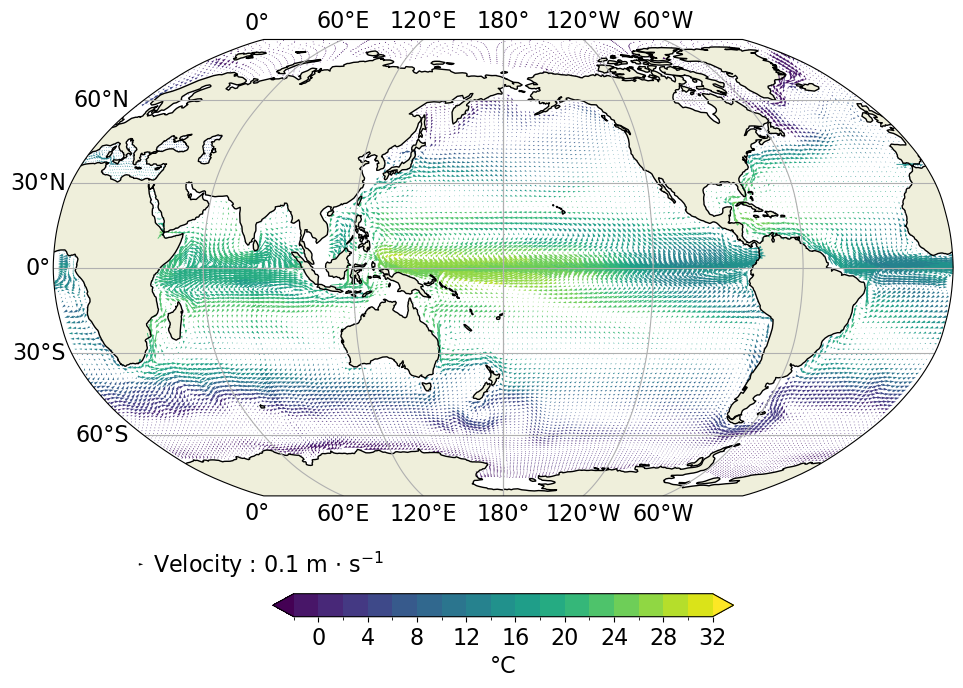

In [41]:
levels = np.arange (-2, 32.001, 2)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='both')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Robinson (central_longitude=180)
fig, ax = plt.subplots ( figsize=(12,7), subplot_kw={'projection':ProjPlot} )
plt.tight_layout()

ux = ue[{udims['z']:0}].mean(dim=udims['t'])
vy = vn[{udims['z']:0}].mean(dim=udims['t'])
uv = np.sqrt (ux*ux + vy*vy)
tt = thetao[{udims['z']:10}].mean(dim=udims['t'])
ux = ux.where(uv!=0, np.nan)

mver = ax.quiver (lon.values, lat.values, 
                  ux.values, vy.values, tt.values, 
                  pivot='tip', scale=20, 
                  width=1E-3, transform=ProjIn,
                  cmap=cmap, norm=norm)
ax.quiverkey (mver, X=0.1, Y=-0.15, U=0.1, label='Velocity : 0.1 m $\cdot$ s$^{-1}$', labelpos='E')

ax.coastlines ()
ax.add_feature (cartopy.feature.LAND)
ax.gridlines (draw_labels=True, crs=ProjIn)

plt.colorbar (mver, orientation='horizontal', ax=fig.axes, label='°C', shrink=0.4)

## Vectors in polar projection

/var/folders/9g/5l6g_l6x1ybgdy3sx2drkm3w0000gp/T/ipykernel_3938/2332050992.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


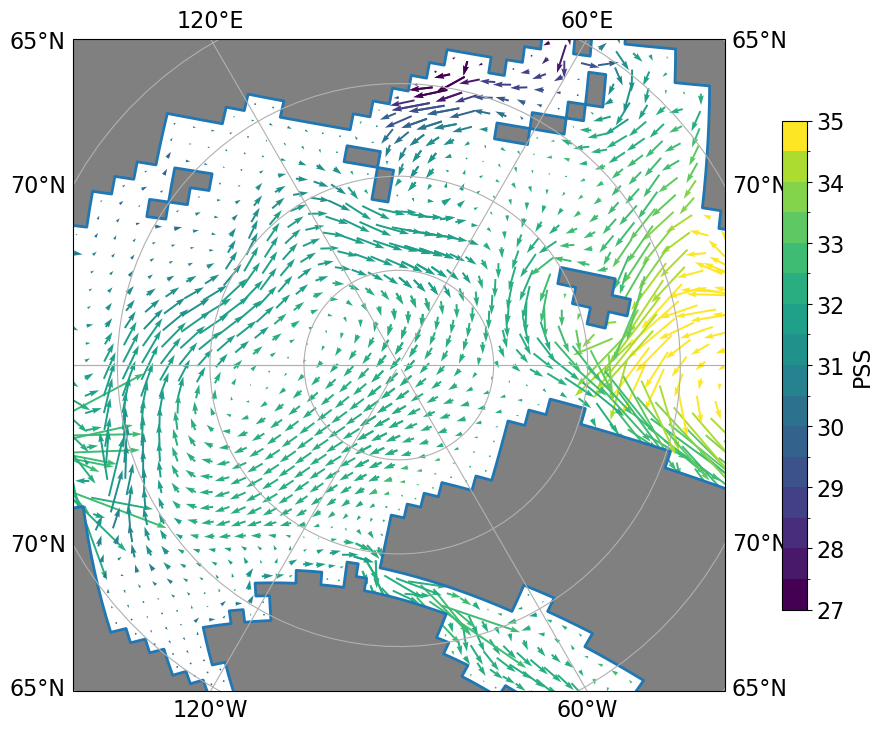

In [42]:
ProjIn = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Orthographic (central_longitude=270, central_latitude=90)
fig, ax = plt.subplots ( figsize=(12,7), subplot_kw={'projection':ProjPlot}, layout='constrained' )
plt.tight_layout()

#levels  = mpl.ticker.MaxNLocator(nbins=19, steps=[1.,  1.5,  2.,  2.5,  5., 10. ]).tick_values(-2,14)
levels = np.linspace ( 27, 35, 17)
palet   = mpl.cm.viridis
colors  = palet (np.linspace(0, 1, len(levels)))
cmap    = mpl.colors.ListedColormap (colors)
norm    = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N)

ux = nemo.lbc ( ue[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
vy = nemo.lbc ( vn[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
uv = np.sqrt (ux*ux + vy*vy)
ss = so[{udims['z']:0}].mean(dim=udims['t'])

# Correct a Cartopy bug in Orthographic projection. See help(nemo.correct_uv) for details
ux, vy = nemo.correct_uv (ux, vy, lat)
    
mver = ax.quiver (lon.values, lat.values, ux.values, vy.values, ss.values,
                    pivot='tail', scale=0.7, width=3E-3, transform=ProjIn, norm=norm, cmap=cmap)

ax.quiverkey (mver, X=0.15, Y=0.95, U=0.1, label='Velocity : 0.1 m$\cdot$ s$^{-1}$', labelpos='E', 
              linewidth=3, color='red')

width = 0.3 ; ax.set_xlim (-Ra*width, Ra*width) ; ax.set_ylim (-Ra*width, Ra*width)

ax.add_feature (coast_poly, facecolor='grey', edgecolor=foreground, lw=2)

ax.gridlines  (draw_labels=True, crs=ProjIn)

plt.colorbar (mver, orientation='vertical', ax=fig.axes, label='PSS', shrink=0.75)

## Streamlines

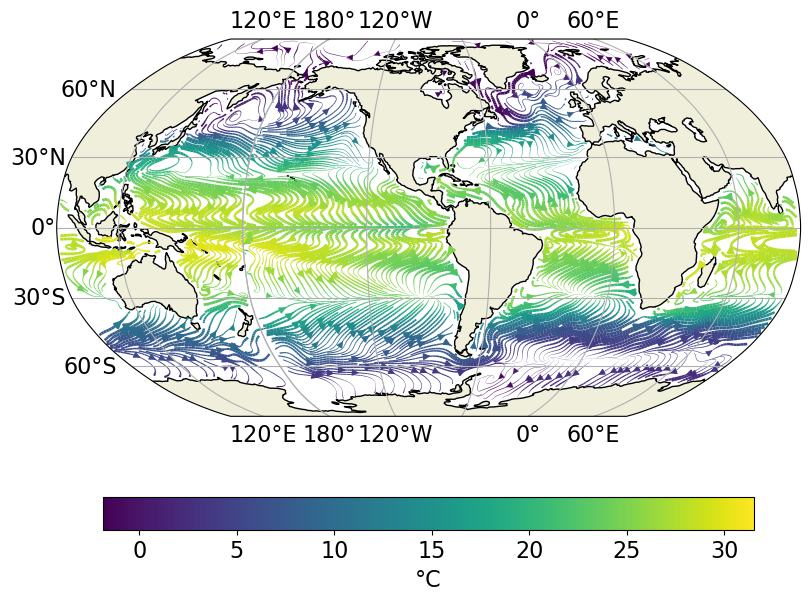

In [43]:
ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Robinson    (central_longitude=270)
fig = plt.figure (figsize=(12,7))
ax = fig.add_subplot (1, 1, 1, projection=ProjPlot)

ux = nemo.lbc_plot ( ue[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
vy = nemo.lbc_plot ( vn[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
uv = np.sqrt (ux*ux + vy*vy)
tt = thetao[{udims['z']:0}].mean(dim=udims['t'])

col = ax.streamplot ( lon.values, lat.values, ux.values, vy.values, transform=ProjIn, density=7, color=tt.values,
                     linewidth=np.minimum (2,uv.values*20) ) 

ax.set_global ()
ax.coastlines ()
ax.gridlines  (draw_labels=True, crs=ProjIn)
ax.add_feature (cartopy.feature.LAND)

plt.colorbar (col.lines, orientation='horizontal', ax=fig.axes, label='°C', shrink=0.7)

## Streamlines in polar projection

jmin=75, jmax=148, imin=0, imax=182


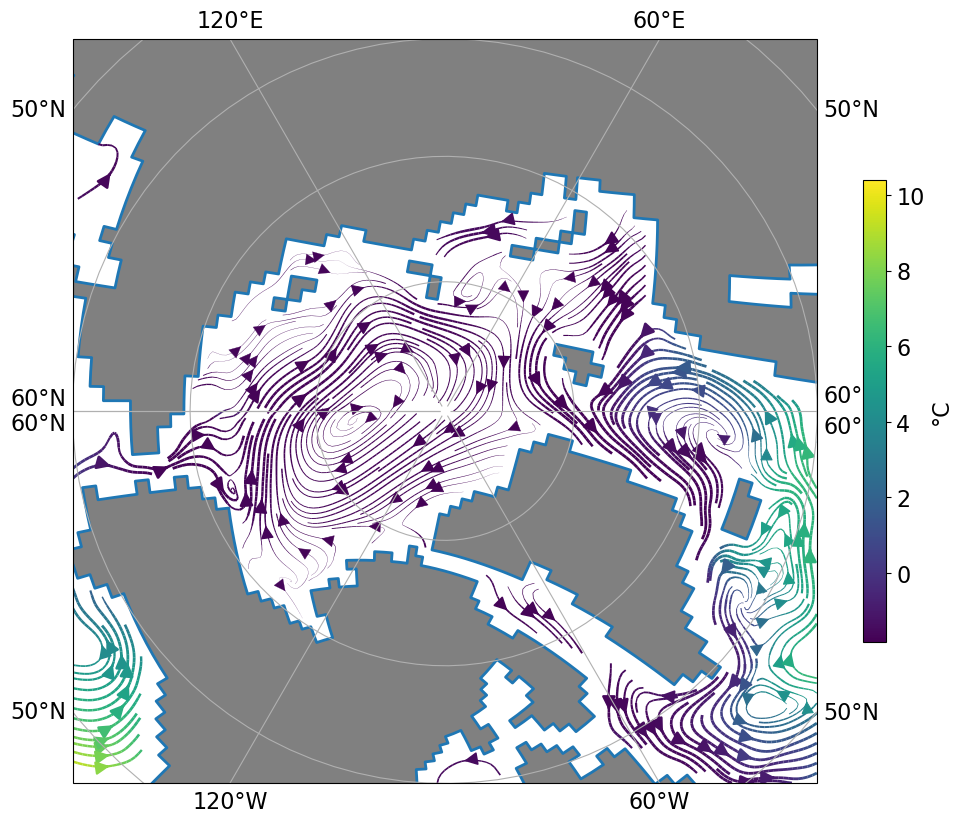

In [44]:
np.seterr (divide='ignore', invalid='ignore')

ProjIn   = ccrs.PlateCarree (central_longitude=0)
ProjPlot = ccrs.Orthographic (central_longitude=270, central_latitude=90)

fig, ax = plt.subplots ( figsize=(12,12), subplot_kw={'projection':ProjPlot} )


width = 0.5 ; ax.set_xlim (-Ra*width, Ra*width) ; ax.set_ylim (-Ra*width, Ra*width)

ux = nemo.lbc ( ue[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
vy = nemo.lbc ( vn[{udims['z']:0}].mean(dim=udims['t']), nperio, 'T' )
uv = np.sqrt (ux*ux + vy*vy)
tt = nemo.lbc (thetao[{udims['z']:0}].mean(dim=udims['t']),  nperio, 'T' )

ux, vy = nemo.correct_uv (ux, vy, lat) # Correct a Cartopy bug in polar projection

jmin=jeq+2 ; jmax = jpj-1
imin, imax = 0, jpi
print ( f'{jmin=}, {jmax=}, {imin=}, {imax=}' )

col = ax.streamplot (lon.values[jmin:jmax,imin:imax], lat.values[jmin:jmax,imin:imax], 
                     ux.values [jmin:jmax,imin:imax], vy.values [jmin:jmax,imin:imax],
                     transform=ProjIn, density=5,
                     color    = tt.values[jmin:jmax,imin:imax],
                     linewidth=np.minimum (2, (uv[jmin:jmax,imin:imax]*50).values), arrowsize=2)

ax.add_feature (coast_poly, facecolor='grey', edgecolor=foreground, lw=2)

ax.gridlines (draw_labels=True, crs=ProjIn)

plt.colorbar (col.lines, orientation='vertical', ax=fig.axes, label='°C', shrink=0.5)

## Barotropic stream function (`bsf`)

Barotropic stream function is defined to within one constant. We can define a point `bsf0` where it is 0 (generally in Eurasia).

In [45]:
bsf0 = nemo.find_ji( 50, 90, lat, lon, out='dict')

In [46]:
bsf = nemo.bsf (uo, e2u*e3u, mask, nperio, bsf0=bsf0).mean(dim=udims['t'], keep_attrs=True)
bsf = nemo.lbc_plot (bsf, nperio=nperio, cd_type='T')

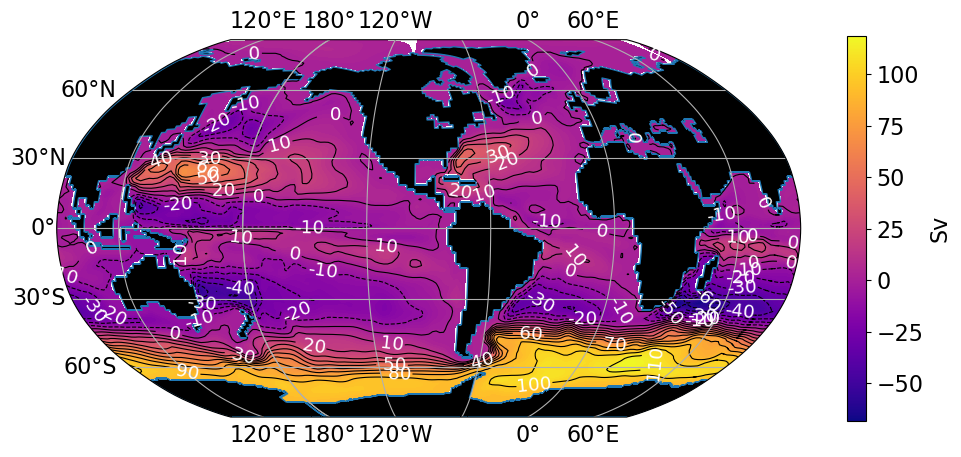

In [47]:
ProjIn   = ccrs.PlateCarree (central_longitude=0) 
ProjPlot = ccrs.Robinson (central_longitude=270) # Plotted projection

# Creates the color palette
cmap = mpl.cm.plasma
norm = mpl.colors.Normalize( vmin=bsf.min(), vmax=bsf.max())
levels = np.arange (-80, 200, 10)
# Creates the figure
fig, ax = plt.subplots ( figsize=(12,5), subplot_kw={'projection':ProjPlot} )
ax.set_global ()

mmap = ax.contourf (lon, lat, bsf,
                    levels = np.linspace (bsf.min(), bsf.max(), 100),
                    cmap=cmap, norm=norm, transform=ProjIn)

mlin = ax.contour  (lon, lat, bsf, transform=ProjIn, colors='k',
                    levels=levels, linewidths=0.8)

ax.clabel ( mlin, colors='w',
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f}'.format, fontsize='small' )

#ax.plot (lon_coast, lat_coast, linewidth=1, color='k' , transform=ProjIn)
ax.gridlines (draw_labels=True, crs=ProjIn)

ax.add_feature (coast_poly, facecolor='black', edgecolor=foreground)

fig.colorbar (mpl.cm.ScalarMappable (norm=norm, cmap=cmap), ax=ax, label='Sv' )

## Meridional stream functions

In [48]:
lat1D, lon1D = nemo.latlon1d (lat, lon)

### Compute meridional stream functions

In [49]:
#%%time
importlib.reload(nemo)
zomsfglo = nemo.msf (vo,        e1v*e3v, lat1D, depthW).mean (dim=udims['t'], keep_attrs=True)
zomsfatl = nemo.msf (vo, atlmsk*e1v*e3v, lat1D, depthW).mean (dim=udims['t'], keep_attrs=True)
zomsfpac = nemo.msf (vo, pacmsk*e1v*e3v, lat1D, depthW).mean (dim=udims['t'], keep_attrs=True)
zomsfind = nemo.msf (vo, indmsk*e1v*e3v, lat1D, depthW).mean (dim=udims['t'], keep_attrs=True)
zomsfipc = nemo.msf (vo, ipcmsk*e1v*e3v, lat1D, depthW).mean (dim=udims['t'], keep_attrs=True)

zomsfatl = zomsfatl.where (zomsfatl.lat > -30, np.nan)
zomsfpac = zomsfpac.where (zomsfpac.lat > -30, np.nan)
zomsfind = zomsfind.where (zomsfind.lat > -30, np.nan)
zomsfipc = zomsfipc.where (zomsfipc.lat > -30, np.nan)

try :
    zomsfatl_nomed = nemo.msf (vo*atlmsk_nomed*e1v*e3v, lat1D, depthW)
    zomsfatl_nomed = zomsfatl_nomed.where (zomsfatl_nomed.lat > -30, np.nan)
except : pass

### Plots meridional stream functions

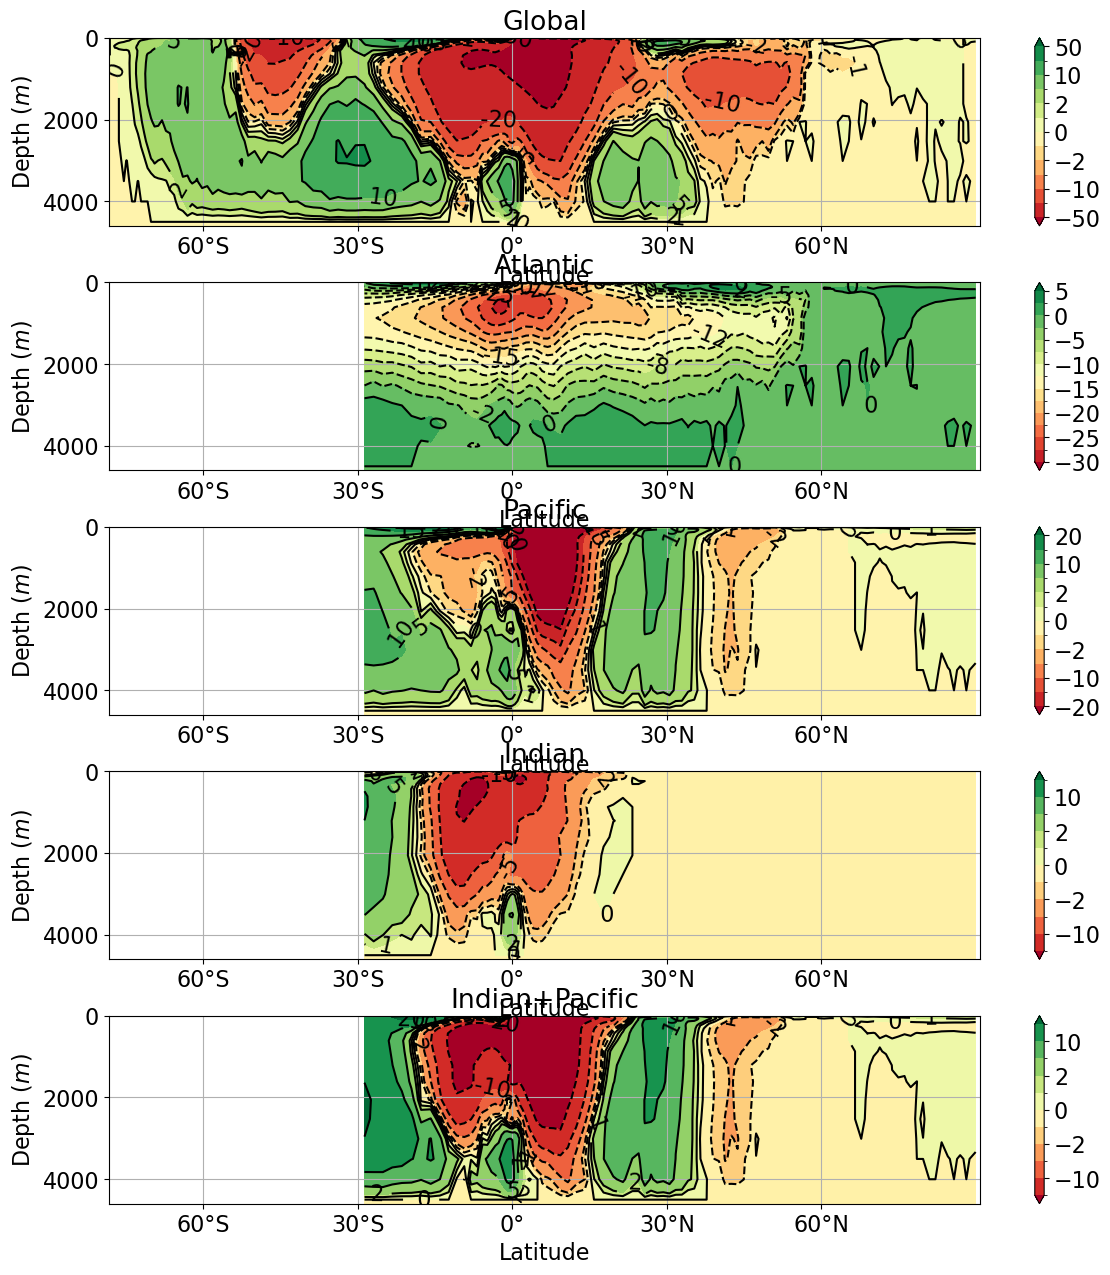

In [50]:
fig, axs = plt.subplots (6, 1, figsize=(12, 15))
axs = axs.ravel()
fig.tight_layout()
fig.subplots_adjust (hspace=0.3, wspace=0.2)

def msfplot (zmsf, ax, levels = 'auto', land='auto') :
    if levels == 'auto' :
        levels = mpl.ticker.MaxNLocator (nbins=15).tick_values(zmsf.min(), zmsf.max())
    palet  = mpl.cm.RdYlGn
    colors = palet (np.linspace(0, 1, len(levels)+1))
    cmap   = mpl.colors.ListedColormap(colors)
    cmap.set_bad ('grey')
    norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')
    
    mmap = ax.contourf (lat1D, depthW, zmsf, levels=levels, cmap=cmap, norm=norm, extend='both')
    mlin = ax.contour  (lat1D, depthW, zmsf, levels=levels, colors='k')
    
    ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.0f} '.format, fontsize='medium' )
    
    if np.all (land != None) : 
        if np.all (land == 'auto') :
            zland = xr.where (np.isnan(zmsf), 1.0, np.nan)
        else : zland = land
        ax.pcolor (lat1D, depthT, zland, cmap='gray', vmin=0, vmax=2, shading='auto')
    
    ax.set_ylim (0, 4600)
    ax.invert_yaxis ()
    ax.set_xlabel ('Latitude') ; ax.set_ylabel ('Depth ($m$)')
    ax.set_xticks ([-60, -30, 0,30, 60])
    ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
    fig.colorbar (mmap, ax=ax)
    ax.grid()

zland = xr.where (np.isnan(zomsfglo), 1.0, np.nan)

ax = axs[0]
levels = [-50, -20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20, 50]
msfplot (zomsfglo, ax, levels=levels, land=zland)
ax.set_title ('Global')

ax = axs[1]
msfplot (zomsfatl, ax, levels='auto', land=zland)
ax.set_title ('Atlantic')

ax = axs[2]
levels = [-20, -15, -10, -5, -2, -1, 0, 1, 2, 5, 10, 15, 20]
msfplot (zomsfpac, ax, levels=levels, land=zland)
ax.set_title ('Pacific')

ax = axs[3]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot (zomsfind, ax, levels=levels, land=zland)
ax.set_title ('Indian')

ax = axs[4]
levels = [-20, -10, -5, -2, -1, 0, 1, 2, 5, 10, 20]
msfplot (zomsfipc, ax, levels=levels, land=zland)
ax.set_title ('Indian+Pacific')

try : 
    ax = axs[5]
    msfplot (zomsfatl_nomed, ax, levels='auto', land=zland)
    axs.set_title ('Atlantic, no Med')
except : 
    ax.set_visible (False)

## Streamlines in vertical slices

### Computes velocities at T points

In [51]:
ut = nemo.u2t (uo, nperio=nperio)
vt = nemo.v2t (vo, nperio=nperio)

### Create a mask for plotting land masses

In [52]:
land = xr.where (np.isnan(thetao[{udims['t']:0}]), 1.0, np.nan)

### Interpolate data on regular vertical levels

#### Creates the levels

In [53]:
dz = thetao.coords[udims['z']][1] - thetao.coords[udims['z']][0]
std_lev = np.arange (thetao.coords[udims['z']][0], 250+dz, dz*0.5)

std_lev = xr.DataArray ( std_lev, dims=('std_lev',), coords=(std_lev,) )
std_lev.attrs.update ( {'units':'m', 'long_name':'Vertical levels (regular)', 'axis':'Z', 'positive':'down'} )

#### Interpolates
Using xarray fonctionnality, interpolates on regular levels

In [54]:
ut_std = ut.interp ({udims['z']:std_lev}, method="linear")
vt_std = vt.interp ({udims['z']:std_lev}, method="linear")
wt_std = wo.interp ({udims['z']:std_lev}, method="linear")

## Equator slice of currents

(182,) -281.99997 1.9999695


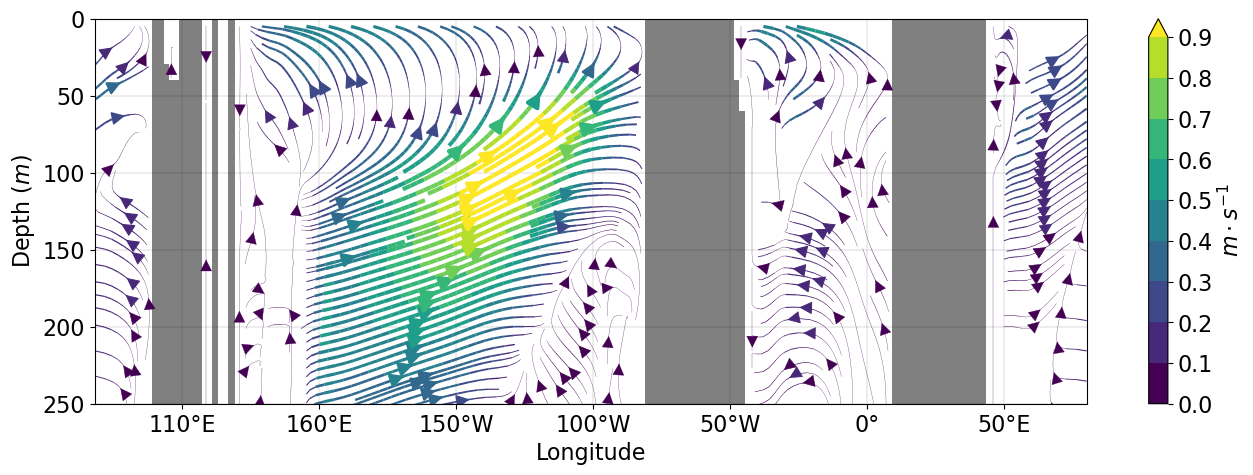

In [55]:
fig = plt.figure (figsize=(16, 5))

levels = np.arange (0, 1, 0.1)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

ax = fig.add_subplot (1, 1, 1)

ux  = ut_std[{udims['y']:jeq}].mean (dim=udims['t']).roll(x=2, roll_coords=False)
wz  = wt_std[{udims['y']:jeq}].mean (dim=udims['t'])
uw  = np.sqrt (ux*ux+wz*wz)

lo_min = lon[{udims['y']:jeq, udims['x']:0}].values 
dx = (lon[{udims['y']:jeq, udims['x']:1}]-lon[{udims['y']:jeq, udims['x']:0}]).values
lox = np.arange(jpi)*dx + lo_min
print (lox.shape, lo_min, dx)

X, Y = np.meshgrid (lox, wz.std_lev)

ax.set_ylim (250,0)
ax.set_xlim (lox.min(), lox.max())

# Size of plot = size of figure * position in the figure
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
Delta_X = fig.get_figwidth ()*np.abs((ax.get_position().xmax-ax.get_position().xmin))
Delta_Y = fig.get_figheight()*np.abs((ax.get_position().ymax-ax.get_position().ymin))

fact_u  = Delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = Delta_Y / np.abs(ymax-ymin)

mstream = ax.streamplot ( X, Y, ux*fact_u, -wz*fact_w, density=3, color=uw.values, 
               linewidth=np.clip (uw.values*5., 0.2, 3),
               arrowsize=2, cmap=cmap, norm=norm) 

ax.pcolor (lon[{udims['y']:jeq}], depthT, land[{udims['y']:jeq}], cmap='gray', vmin=0, vmax=2, shading='auto')

ax.set_xlabel ("Longitude") ; ax.set_ylabel ("Depth ($m$)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

plt.colorbar (mstream.lines, orientation='vertical', ax=fig.axes, label='$m \cdot s^{-1}$')

## Slice of current accros the equator

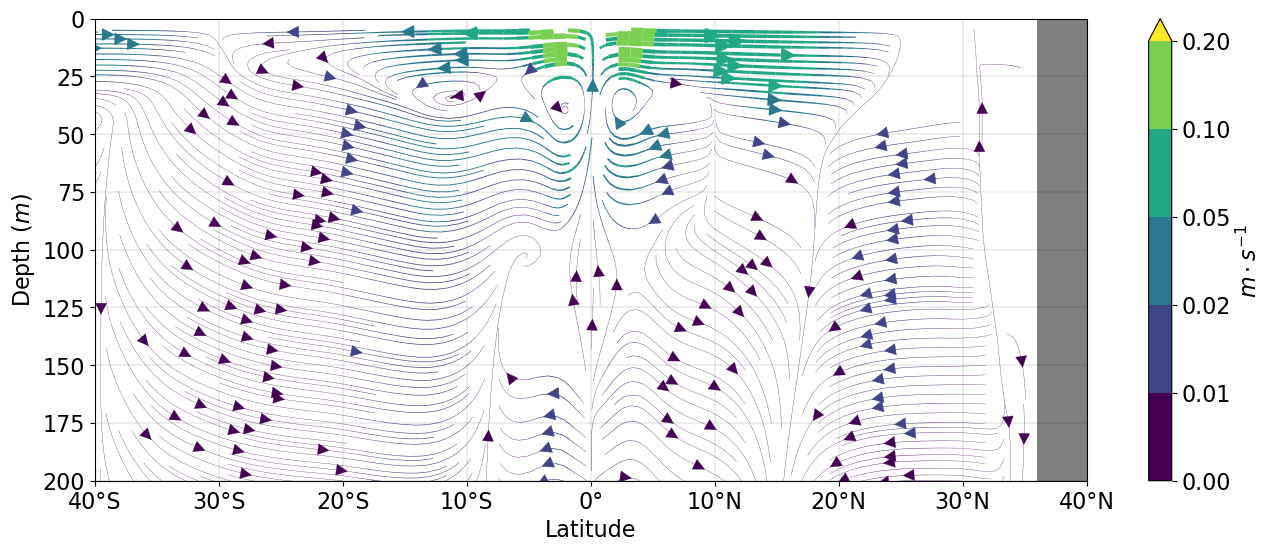

In [56]:
fig = plt.figure ( figsize=(16,6) )
plt.tight_layout () 

# Slice current
xcoupe = 160 
if jeq < 140 : xcoupe = 80
ycoupe = slice (jeq//3, 5*jeq//3)

levels = [0, 0.01, 0.02, 0.05, 0.1, 0.2]
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)))
cmap, norm = mpl.colors.from_levels_and_colors (levels, colors, extend='max')

lat_s = lat[{udims['x']:xcoupe, udims['y']:ycoupe}]

vy = vt_std[{udims['x']:xcoupe, udims['y']:ycoupe}].mean(dim=udims['t'])
wz = wt_std[{udims['x']:xcoupe, udims['y']:ycoupe}].mean(dim=udims['t']) 
vw = np.sqrt (vy*vy+wz*wz)

# On assigne la latitude
vy = vy.assign_coords ({'y':lat_s})
wz = wz.assign_coords ({'y':lat_s})

# Latitude régulière
lat_c = np.linspace ( lat_s.min(), lat_s.max(), 100)
lat_c = xr.DataArray ( lat_c, dims=('lat',), coords=(lat_c,))

vy_c = vy.interp({udims['y']:lat_c})
wz_c = wz.interp({udims['y']:lat_c})
vw_c = np.sqrt (vy_c*vy_c+wz_c*wz_c)

ax = fig.add_subplot (1, 1, 1, adjustable='box')
ax.set_ylim (200,  0)
ax.set_xlim (-40, 40)

# Facteur de ratio horizontal/vertical
xmin,xmax=ax.get_xlim() ; ymin,ymax=ax.get_ylim()
delta_Y = fig.get_figheight()*np.abs((ax.get_position().ymax-ax.get_position().ymin))
delta_X = fig.get_figwidth ()*np.abs((ax.get_position().xmax-ax.get_position().xmin))
fact_v  = delta_X / np.abs(xmax-xmin) / ( Ra*np.pi/180. )
fact_w  = delta_Y / np.abs(ymax-ymin)

X, Y = np.meshgrid(lat_c.values, vy_c.coords[udims['z']].values)

mstream = ax.streamplot (X, Y, (vy_c*fact_v).values, -(wz_c*fact_w).values, density=4,
              color=vw_c.values, 
              linewidth=np.clip (vw_c.values*30., 0.2, 4),
              arrowsize=2, cmap=cmap, norm=norm)

ax.pcolor (lat[{udims['x']:xcoupe, udims['y']:ycoupe}].values, depthT.values, land[{udims['x']:xcoupe, udims['y']:ycoupe}], 
           cmap='gray', vmin=0, vmax=2)

ax.set_xlabel ("Latitude") ; ax.set_ylabel ("Depth ($m$)")
ax.grid (color='k', linestyle='-', linewidth=0.1)
ax.xaxis.set_major_formatter(cartopy.mpl.ticker.LatitudeFormatter (number_format='.0f'))

plt.colorbar (mstream.lines, orientation='vertical', ax=fig.axes, label='$m \cdot s^{-1}$')

## Using 1d lon and lat for simplified and faster plots

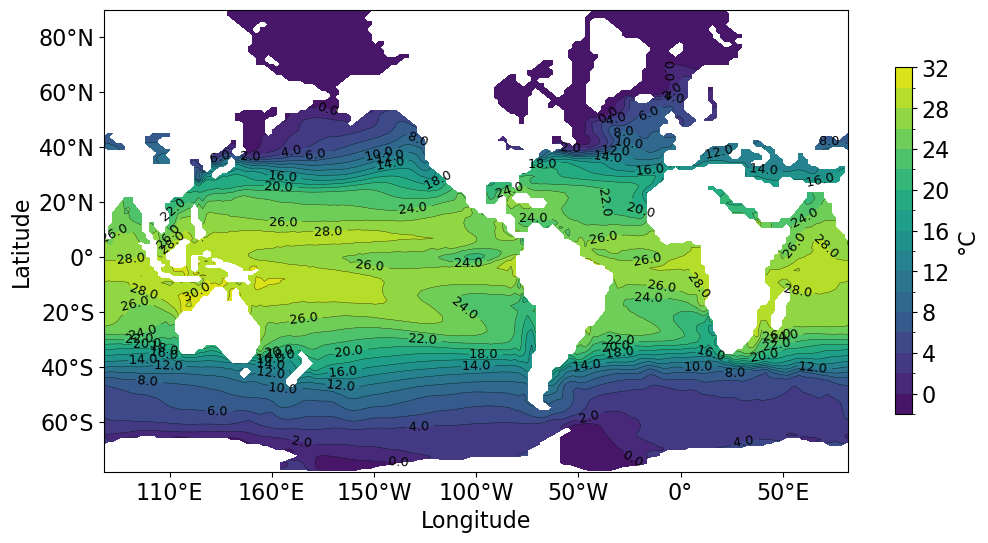

In [57]:
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6))
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data. 
tt = thetao[{udims['t']:0, udims['z']:0}]

# Color filing
mmap = ax.contourf (lon1D, lat1D, tt, cmap=cmap, norm=norm, levels=levels )

# Contour lines
mlin = ax.contour (lon1D, lat1D, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Longitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))

ax.set_ylabel ('Latitude')
ax.yaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C")

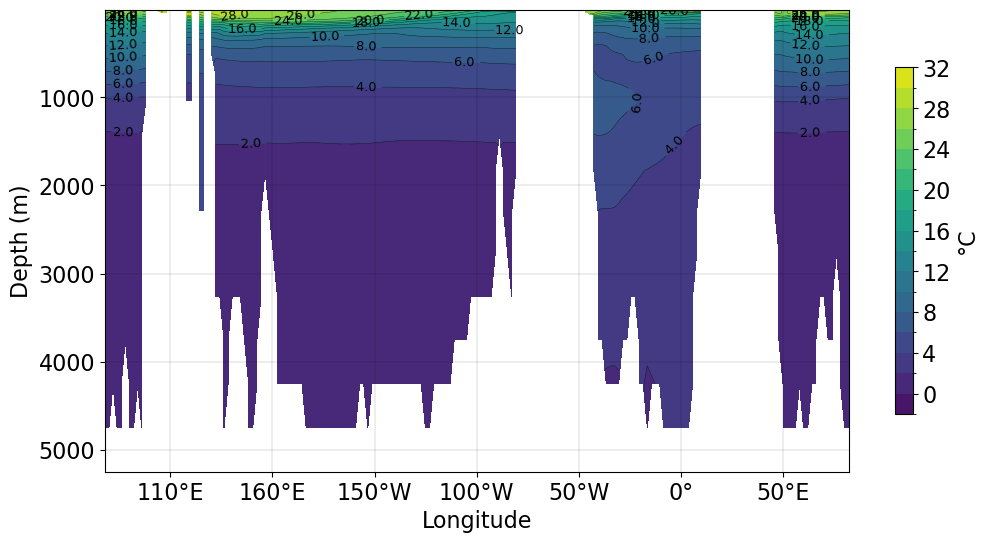

In [58]:
levels = mpl.ticker.MaxNLocator (nbins=17).tick_values (-2, 32)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6))
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data. 
tt = thetao[{udims['t']:0, udims['y']:jeq}]

# Color filing
mmap = ax.contourf (lon1D, depthT, tt, cmap=cmap, norm=norm, levels=levels )
ax.invert_yaxis()

# Contour lines
mlin = ax.contour (lon1D, depthT, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Longitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LongitudeFormatter(number_format='.0f'))
ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C")

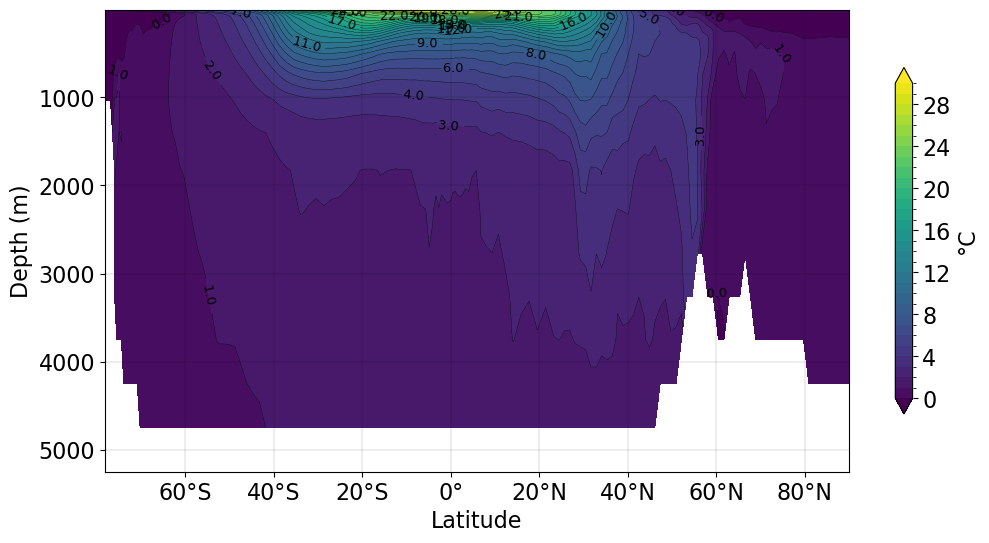

In [59]:
levels = mpl.ticker.MaxNLocator (nbins=33).tick_values (-0, 30)
palet  = mpl.cm.viridis
colors = palet (np.linspace (0, 1, len(levels)+1))
cmap   = mpl.colors.ListedColormap(colors)
cmap.set_bad ('grey')
norm   = mpl.colors.BoundaryNorm (levels, ncolors=cmap.N+1, clip=False, extend='both')

# Creates the figure
fig = plt.figure (figsize=(12,6))
# Creates the viewport
ax = fig.add_subplot (1, 1, 1)

# Select data. 
tt = thetao[{udims['t']:0}].mean(dim=(udims['x']))

# Color filing
mmap = ax.contourf (lat1D, depthT, tt, cmap=cmap, norm=norm, levels=levels, extend='both' )
ax.invert_yaxis()

# Contour lines
mlin = ax.contour (lat1D, depthT, tt, colors='k', levels=levels, linewidths=0.25)

# Add labels to contour lines
ax.clabel (mlin, colors=['k'], manual=False,  # Automatic placement
        inline=True,  # Cut the line where the label will be placed.
        fmt='{:3.1f} '.format, fontsize='xx-small' )

ax.set_xlabel ('Latitude')
ax.xaxis.set_major_formatter (cartopy.mpl.ticker.LatitudeFormatter(number_format='.0f'))
ax.set_ylabel ("Depth (m)")
ax.grid (color='k', linestyle='-', linewidth=0.1)

# Color bar
plt.colorbar (mmap, orientation='vertical', shrink=0.75, ax=fig.axes, label="°C", extend='both')

# To do

## Streamlines in vertical sections. 
The present solution uses an interpolation of the data on a regular grid, as Matplotlib `streamplot` requires a regular grid. Or to understand the use of [transformations](https://matplotlib.org/stable/tutorials/advanced/transforms_tutorial.html) in Matplotlib.


# That's all folks !

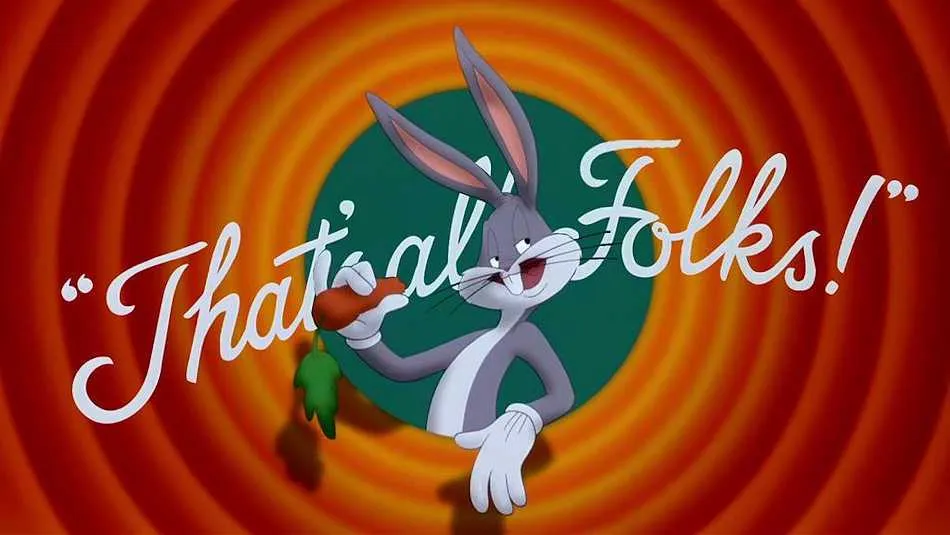

In [60]:
import requests
from IPython.display import Image

Bunny = GetLogo ("https://substackcdn.com/image/fetch/w_1456,c_limit,f_webp,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2F2f95d3fe-13e7-4220-84b1-9c12d760f233_950x535.jpeg"
, 'Bugs_Bunny.jpeg')

Image (filename='Bugs_Bunny.jpeg', width=600)